In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add code directory to path
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), 'code'))

In [3]:
from tempfile import TemporaryDirectory

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from config import load_config
from embedding import get_embeddings, load_model, load_dataset
from plm_base import plm_init

In [6]:
# get distances between all pairs of embeddings
from scipy.spatial.distance import pdist, squareform, cdist

In [23]:
config = load_config("configs/config_PTE.yaml")
sequences_df = pd.read_csv(config["dataset_path"])
wt_seq = sequences_df.loc[0]
embeddings = np.load(config["embeddings_path"])
wt_embedding = embeddings[0]

Loaded configuration:
  root_path: /home/labs/fleishman/omripo/Projects/adaptive_learning
  data_dir_name: data
  pretraining_dir_name: pretraining
  bootstrap_dir_name: bootstrap
  results_dir_name: results
  enzyme: PTE
  substrate: malathion
  dataset_filename: adaptive_learning_stage_0.csv
  tag: zero_shot
  weights_filename: final_model.pt
  model_type: plm
  finetune: False
  opmode: flat
  train_type: msa_backbone
  nmuts_column: num_muts
  sequence_column_name: full_seq
  activity_column_name: inactive
  first_column_name: I106
  last_column_name: M317
  plm_name: esm2_t12_35M_UR50D
  ref_seq: DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDIGRDVSLLAEVSRAADVHIVAATGLWFDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKATPFQELVLKAAARASLATGVPVTTHTAASQRDGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDRVNPDGMAFIPLRVIPFLREKGVPQETLAGITVTNPARFLSPTLRAS
  bootstrap_indices_prefix: indices
  train_indices: all
  

In [24]:
positive_aa = list("RHK")
negative_aa = list("DE")
polar_uncharged_aa = list("STNQ")
special_aa = list("CGP")
hydrophobic_aa = list("AVILMFYW")
amino_acids = positive_aa + negative_aa + polar_uncharged_aa + special_aa + hydrophobic_aa

In [25]:
pos_col_pairs = list(zip(sequences_df.columns[:8], config["pos_to_use"]))
position_specific_datasets = {}
for pos_in_df, pos_in_seq in pos_col_pairs:
    rows = []
    for aa in amino_acids:
        if aa == pos_in_df[0]:
            continue
        row = wt_seq.copy()
        row[pos_in_df] = aa
        row["full_seq"] = row["full_seq"][:pos_in_seq - 1] + aa + row["full_seq"][pos_in_seq:]
        rows.append(row)
    position_specific_datasets[pos_in_df] = pd.DataFrame(rows, index=[aa for aa in amino_acids if aa != pos_in_df[0]])

In [26]:
position_specific_datasets["I106"]

,I106,F132,H254,H257,L271,L303,F306,M317,num_muts,full_seq,inactive,pad_regions,serial_number
R,R,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
H,H,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
K,K,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
D,D,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
E,E,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
S,S,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
T,T,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
N,N,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
Q,Q,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
C,C,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101


In [27]:
plm_init(config["root_path"])
model = load_model(plm_name=config["plm_name"])

In [28]:
position_specific_embeddings = {}

with TemporaryDirectory() as temp_dir:
    for pos, df in position_specific_datasets.items():
        df.to_csv(os.path.join(temp_dir, "temp_dataset.csv"), index=False)
        dataset = load_dataset(
            dataset_path=os.path.join(temp_dir, "temp_dataset.csv"),
            model=model,
            cache=False
        )
        embeddings = get_embeddings(
            dataset=dataset,
            model=model,
            positions=config["pos_to_use"],
            opmode="flat"
        )
        position_specific_embeddings[pos] = embeddings[0]

[INFO] Tokenizing sequences, this may take a while


Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1
[INFO] Tokenizing sequences, this may take a while
Processed batch 1/1


In [29]:
position_specific_delta_embeddings = {}
for pos, emb in position_specific_embeddings.items():
    delta_emb = emb - wt_embedding
    position_specific_delta_embeddings[pos] = delta_emb

In [38]:
# find delta embedding max distance
total_max_dist = 0
for pos, delta_emb in position_specific_delta_embeddings.items():
    distances = squareform(pdist(delta_emb, metric='cosine'))
    max_dist = np.max(distances)
    if max_dist > total_max_dist:
        total_max_dist = max_dist
total_max_dist

np.float64(0.8213085136679432)

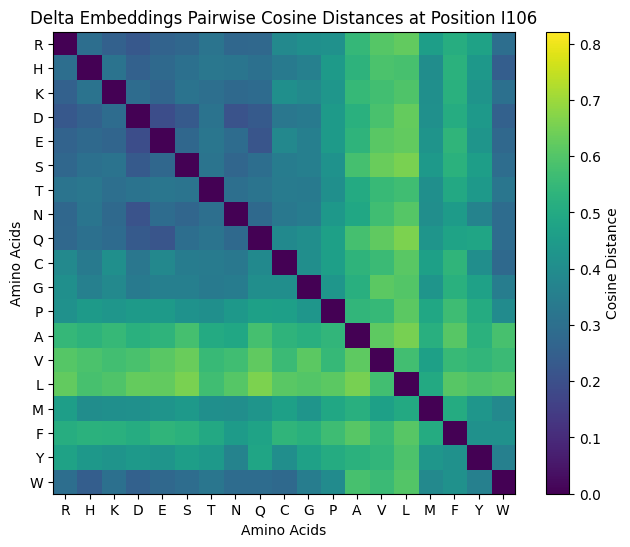

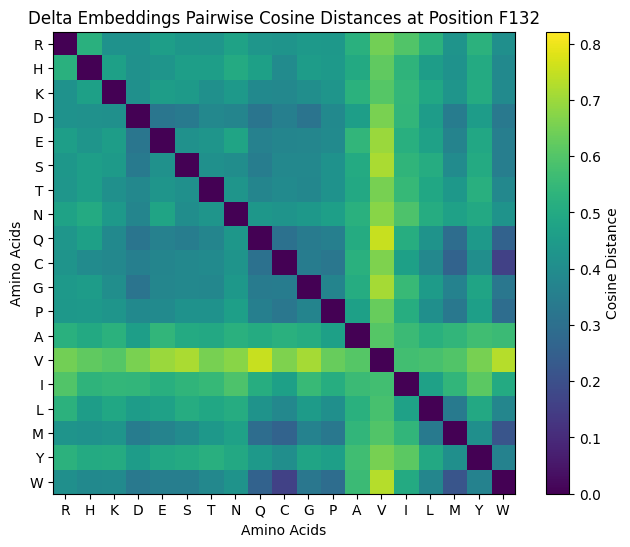

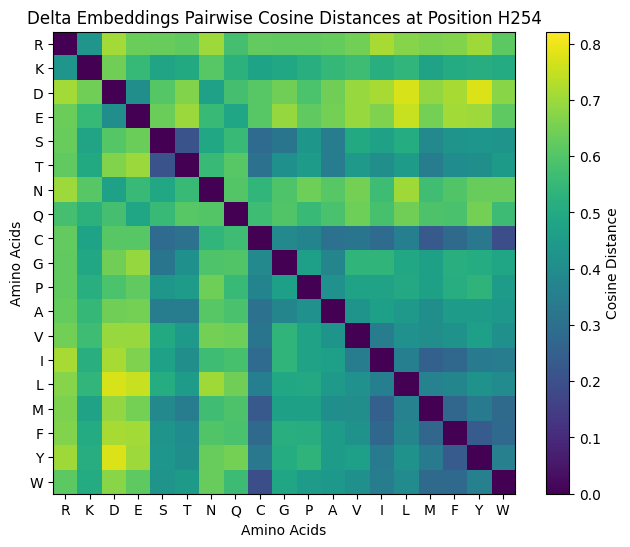

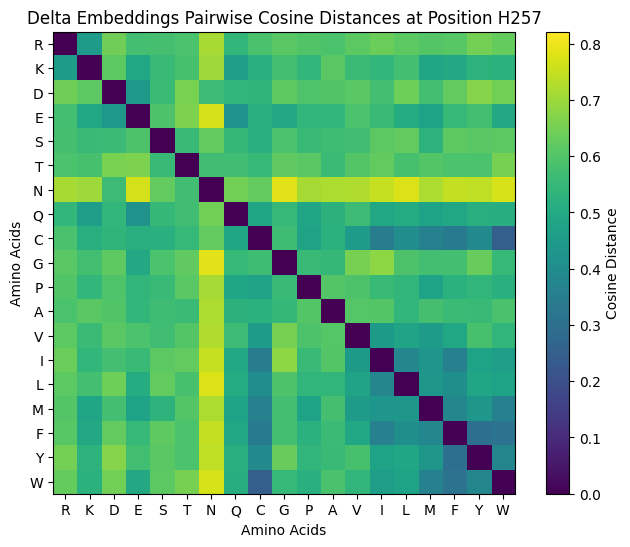

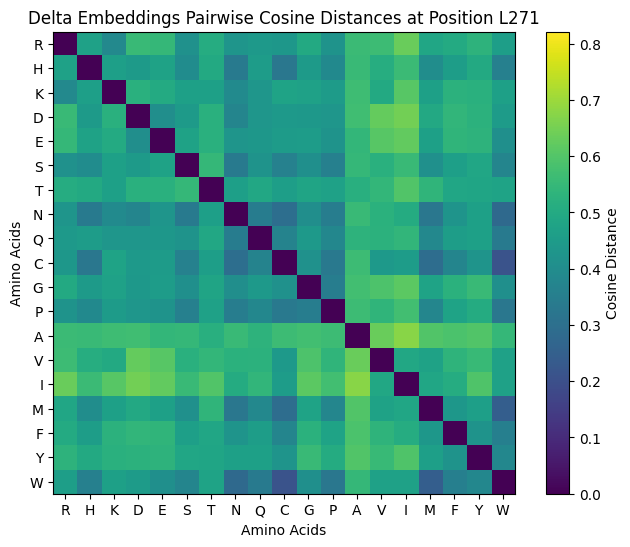

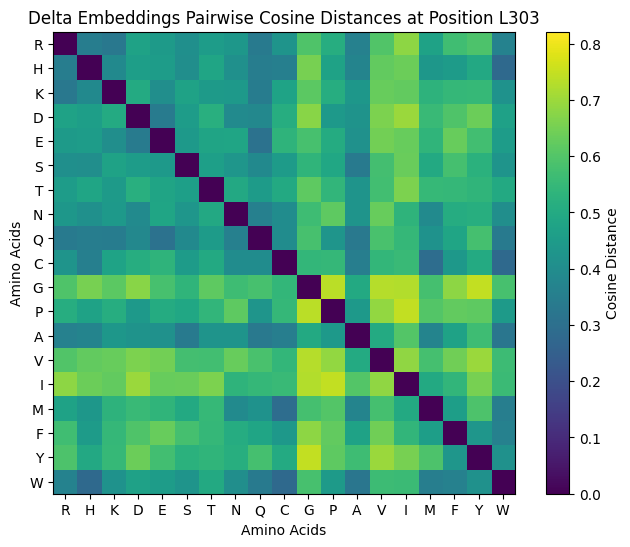

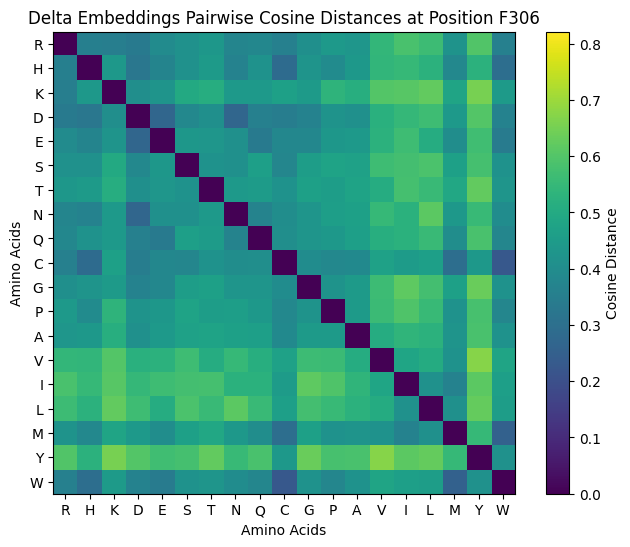

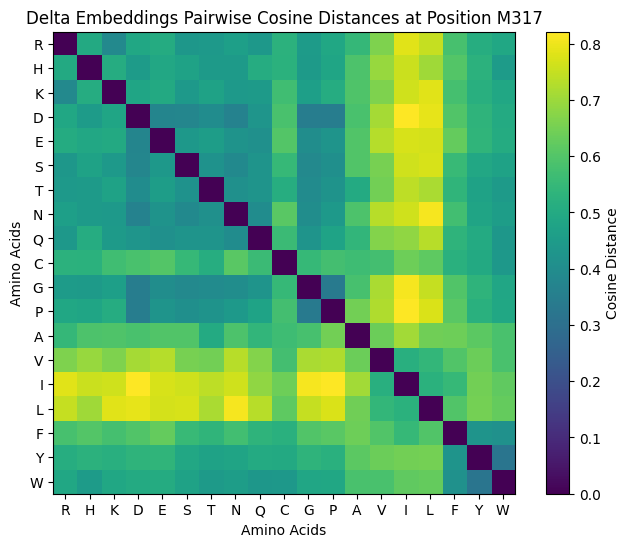

In [39]:
# for each position, plot the pairwise distances between amino acid embeddings
for pos, delta_emb in position_specific_delta_embeddings.items():
    distances = squareform(pdist(delta_emb, metric='cosine'))
    df = position_specific_datasets[pos]
    plt.figure(figsize=(8, 6))
    plt.imshow(distances, cmap='viridis', vmin=0, vmax=total_max_dist)
    plt.colorbar(label='Cosine Distance')
    plt.xticks(ticks=range(len(df.index)), labels=df.index)
    plt.yticks(ticks=range(len(df.index)), labels=df.index)
    plt.title(f'Delta Embeddings Pairwise Cosine Distances at Position {pos}')
    plt.xlabel('Amino Acids')
    plt.ylabel('Amino Acids')
    plt.show()

/tmp/ipykernel_1999159/2959528111.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data.values(), labels=boxplot_data.keys())


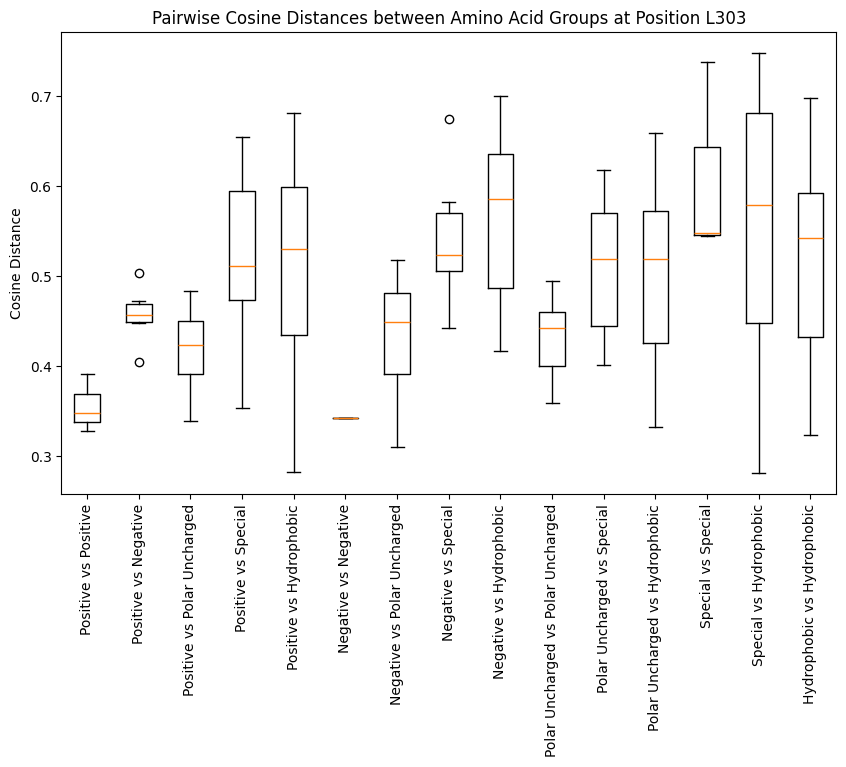

In [33]:
# box plot distances between different groups of amino acids at position I106
# I.e., distances between positive vs negative, positive vs hydrophobic, etc.
pos = "L303"
delta_emb = position_specific_delta_embeddings[pos]
distances = squareform(pdist(delta_emb, metric='cosine'))
df = position_specific_datasets[pos]
group_labels = []
for aa in df.index:
    if aa in positive_aa:
        group_labels.append("Positive")
    elif aa in negative_aa:
        group_labels.append("Negative")
    elif aa in polar_uncharged_aa:
        group_labels.append("Polar Uncharged")
    elif aa in special_aa:
        group_labels.append("Special")
    elif aa in hydrophobic_aa:
        group_labels.append("Hydrophobic")
    else:
        group_labels.append("Other")
group_labels = np.array(group_labels)
boxplot_data = {}
for i, label_i in enumerate(group_labels):
    for j, label_j in enumerate(group_labels):
        if i >= j:
            continue
        pair_label = f"{label_i} vs {label_j}"
        if pair_label not in boxplot_data:
            boxplot_data[pair_label] = []
        boxplot_data[pair_label].append(distances[i, j])
plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data.values(), labels=boxplot_data.keys())
plt.xticks(rotation=90)
plt.ylabel('Cosine Distance')
plt.title(f'Pairwise Cosine Distances between Amino Acid Groups at Position {pos}')
plt.show()

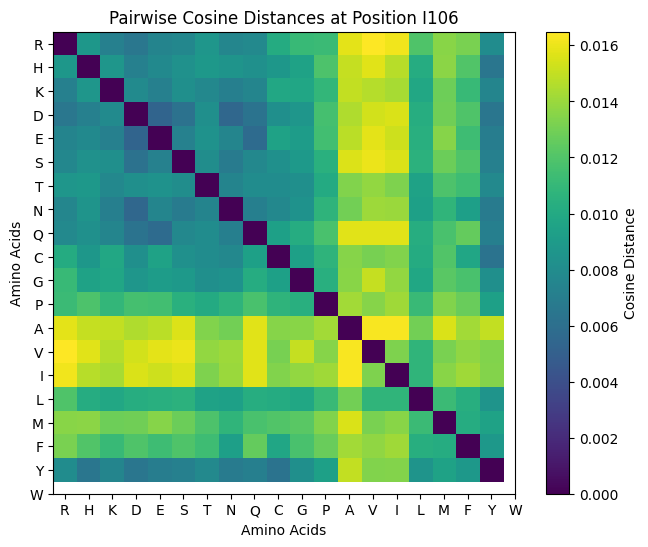

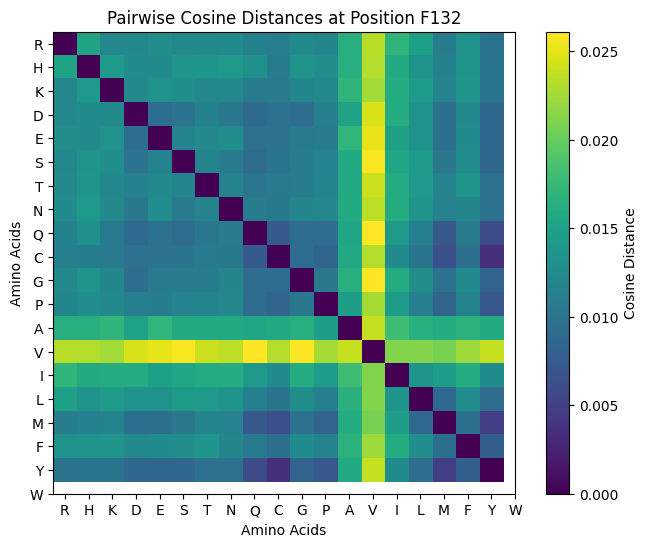

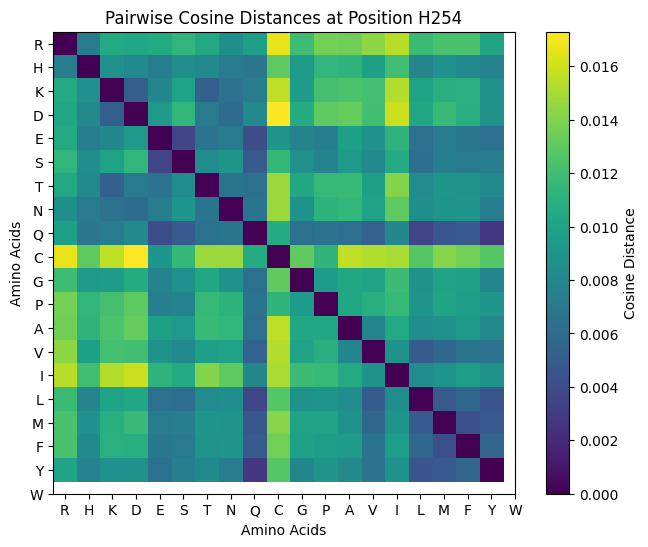

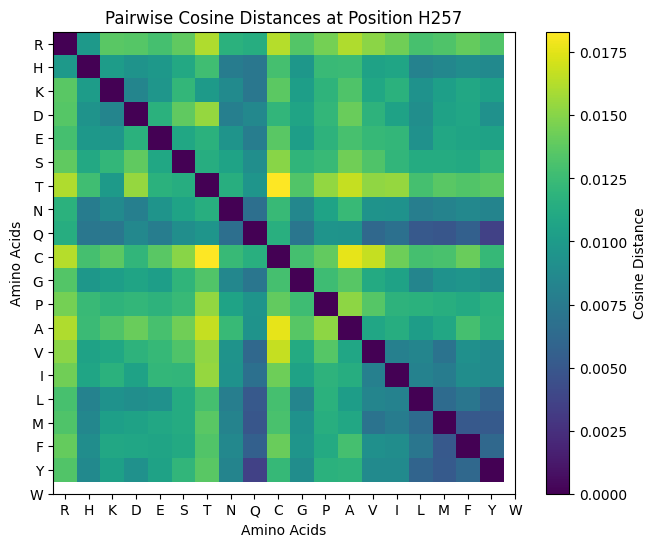

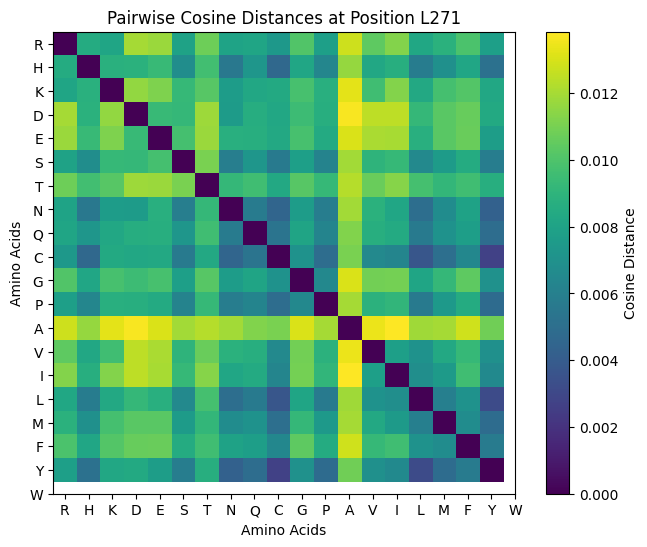

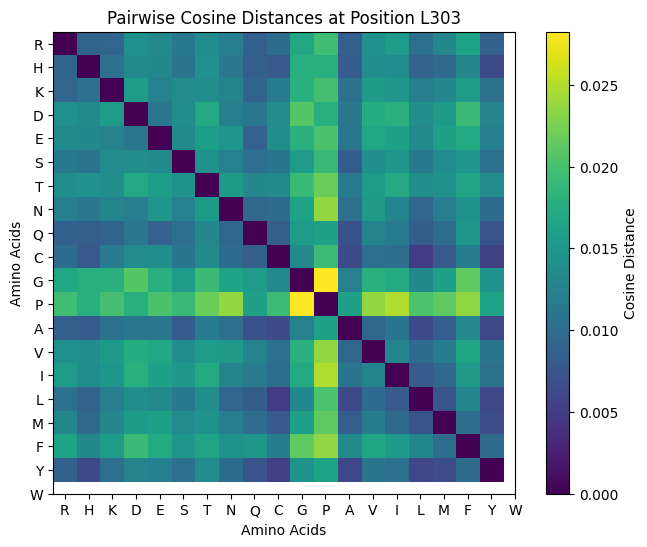

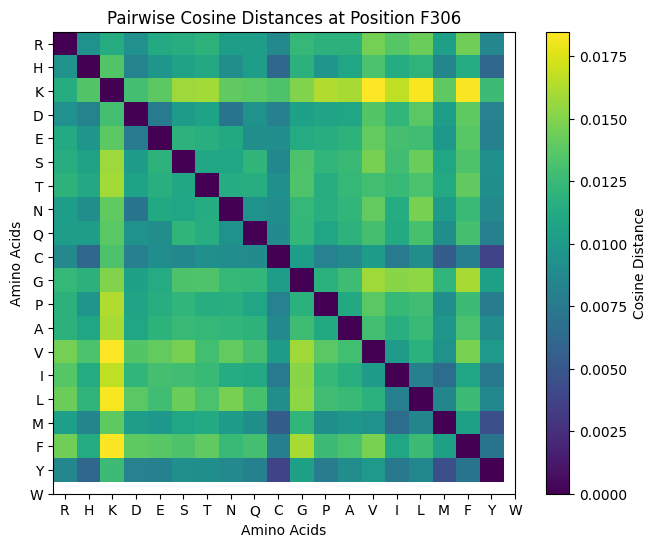

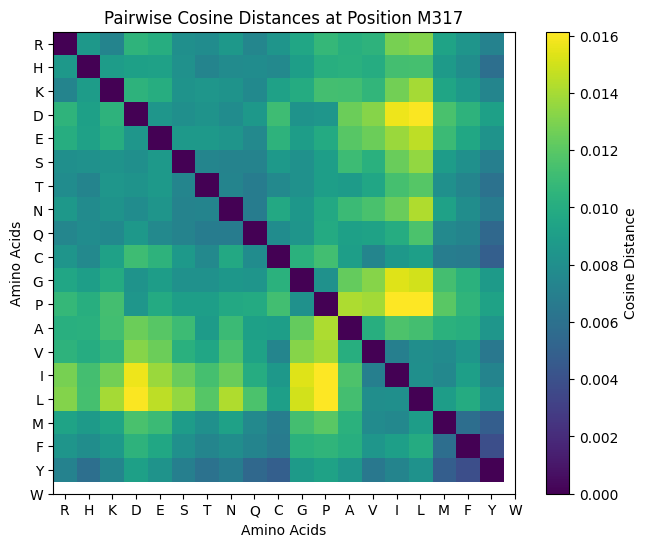

In [34]:
# for each position, plot the pairwise distances between amino acid embeddings
for pos, delta_emb in position_specific_embeddings.items():
    distances = squareform(pdist(delta_emb, metric='cosine'))
    plt.figure(figsize=(8, 6))
    plt.imshow(distances, cmap='viridis')
    plt.colorbar(label='Cosine Distance')
    plt.xticks(ticks=range(len(amino_acids)), labels=amino_acids)
    plt.yticks(ticks=range(len(amino_acids)), labels=amino_acids)
    plt.title(f'Pairwise Cosine Distances at Position {pos}')
    plt.xlabel('Amino Acids')
    plt.ylabel('Amino Acids')
    plt.show()

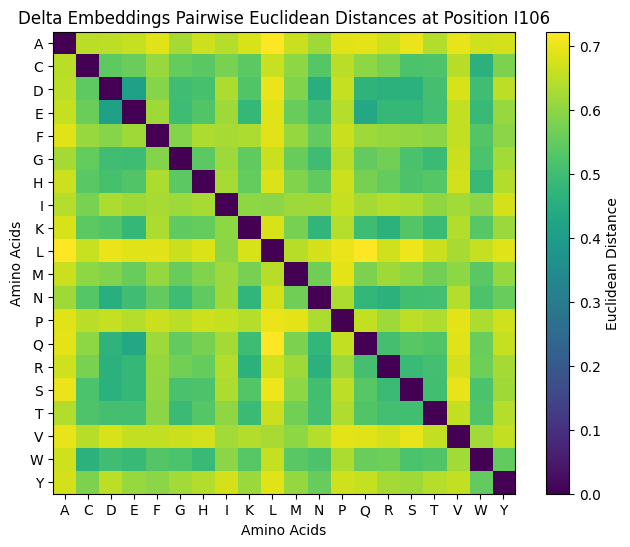

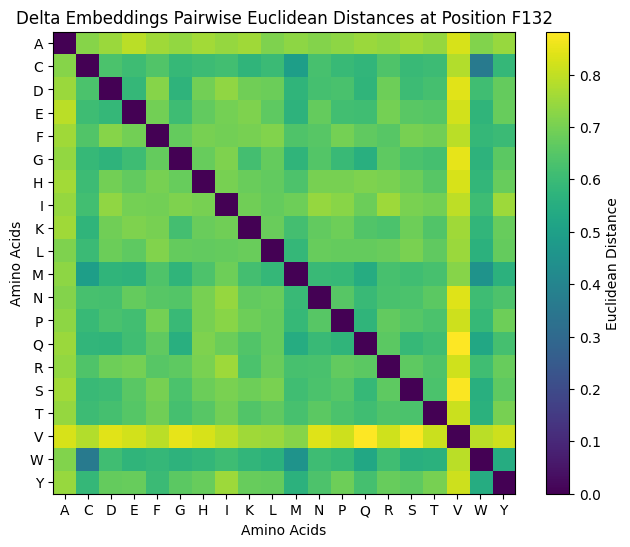

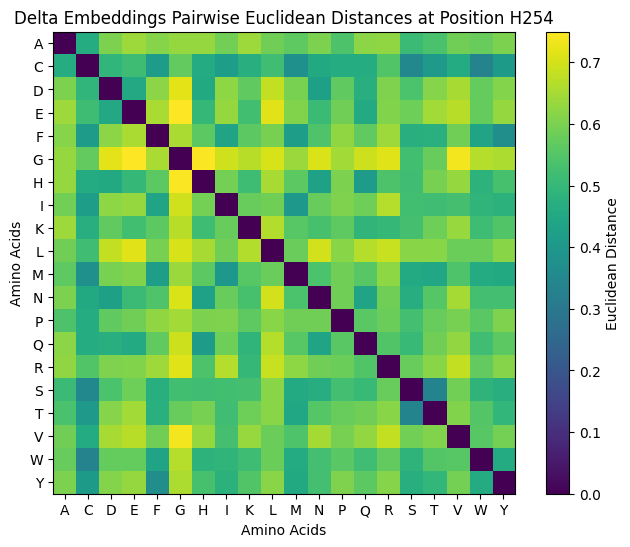

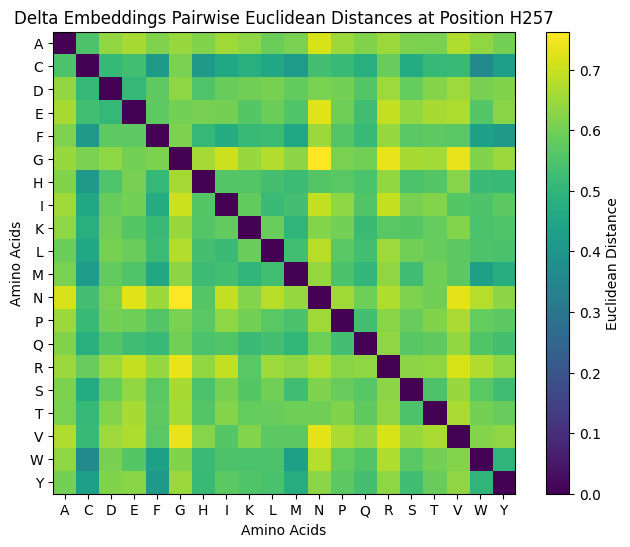

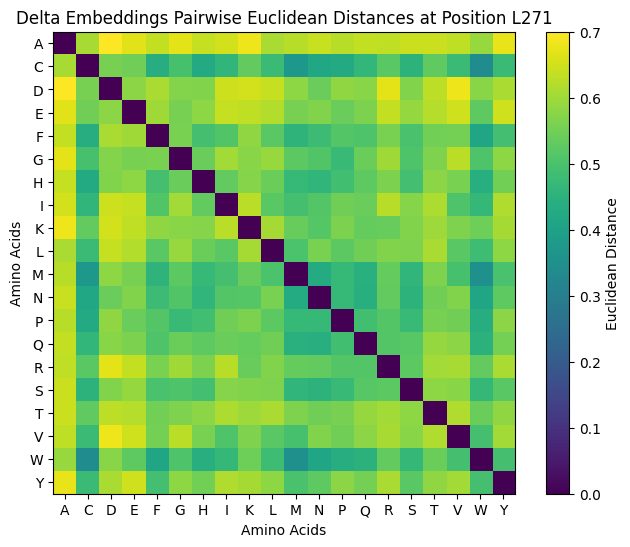

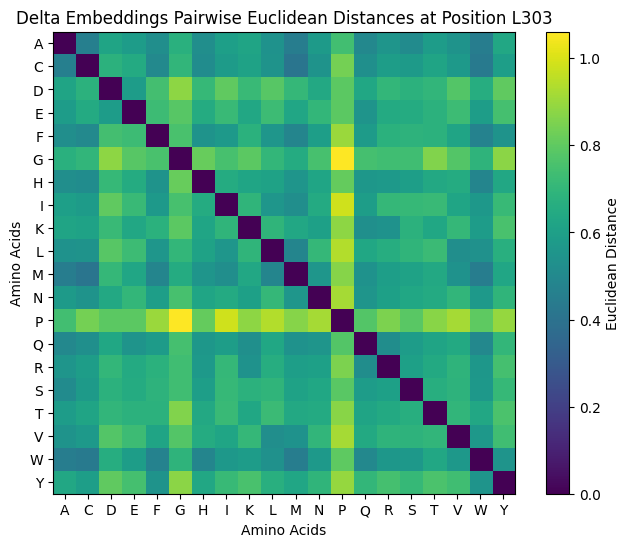

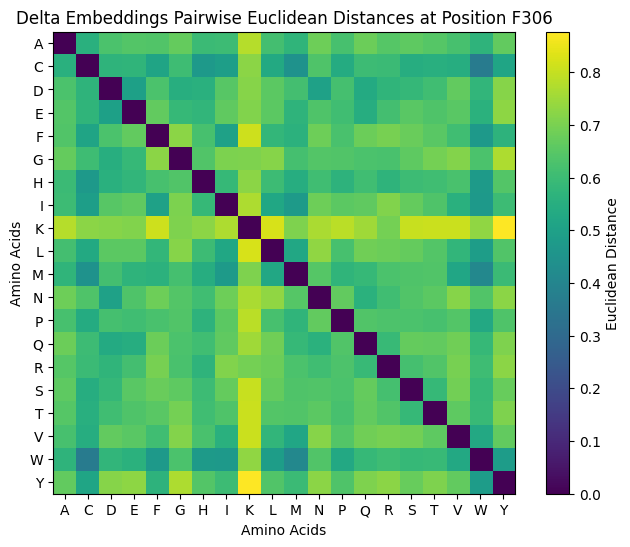

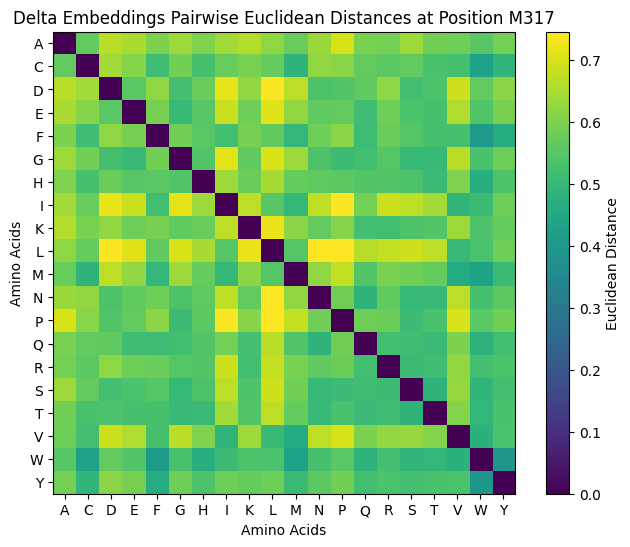

In [98]:
# for each position, plot the pairwise distances between amino acid embeddings
for pos, delta_emb in position_specific_delta_embeddings.items():
    distances = squareform(pdist(delta_emb, metric='euclidean'))
    plt.figure(figsize=(8, 6))
    plt.imshow(distances, cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.xticks(ticks=range(len(amino_acids)), labels=amino_acids)
    plt.yticks(ticks=range(len(amino_acids)), labels=amino_acids)
    plt.title(f'Delta Embeddings Pairwise Euclidean Distances at Position {pos}')
    plt.xlabel('Amino Acids')
    plt.ylabel('Amino Acids')
    plt.show()

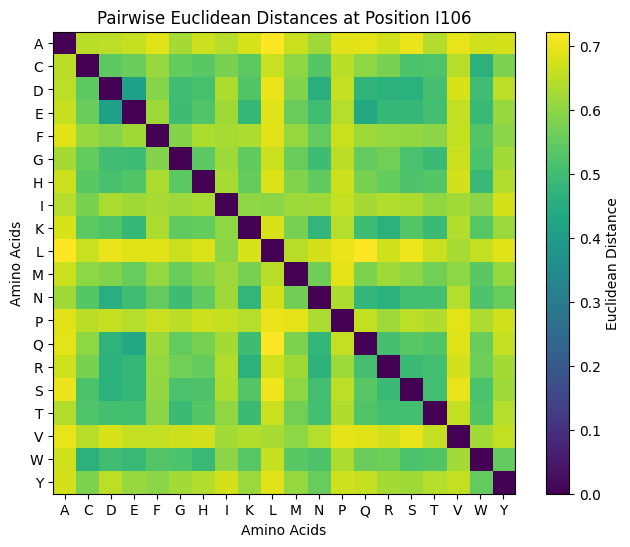

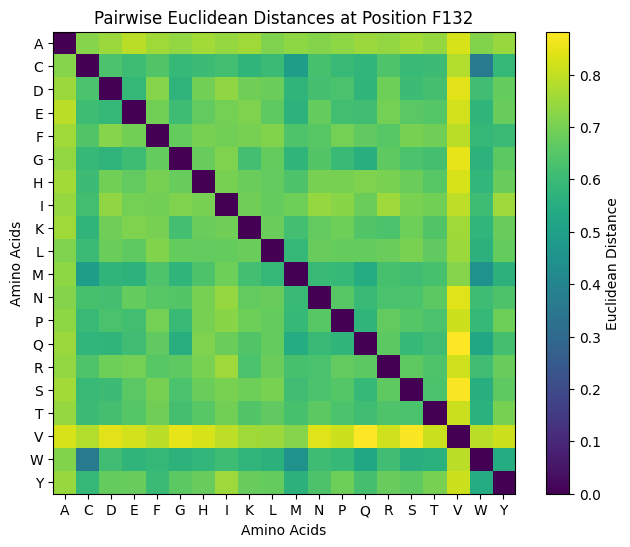

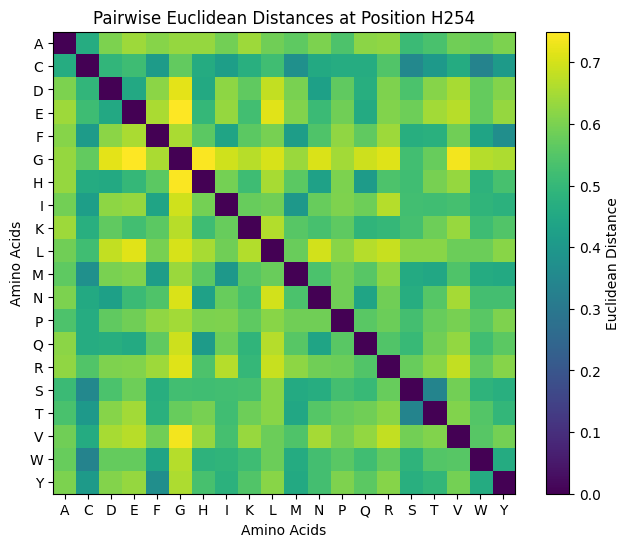

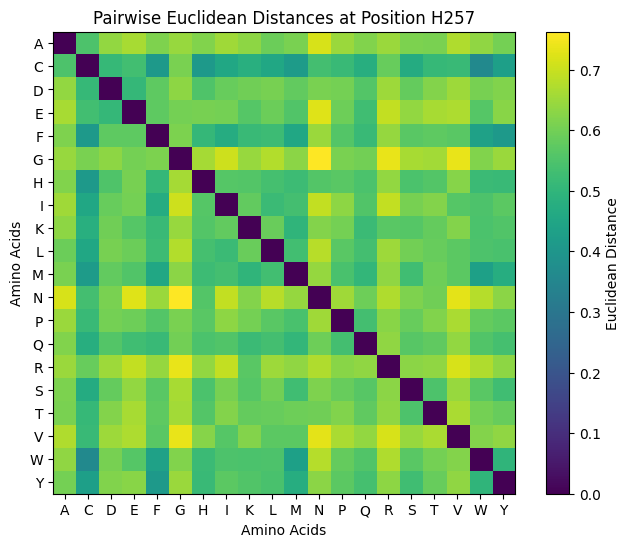

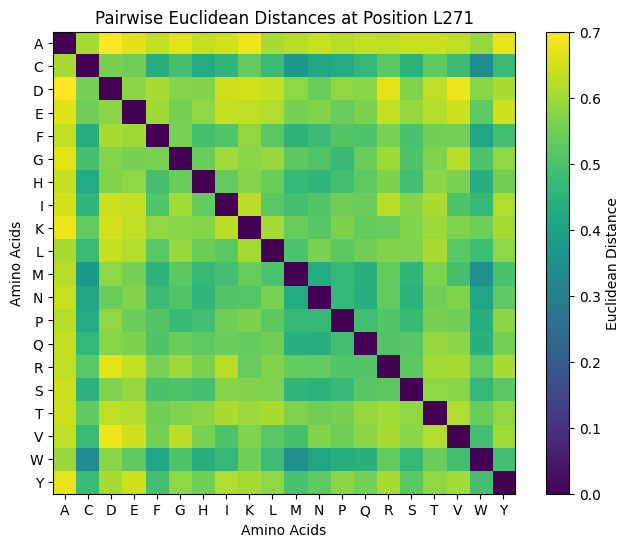

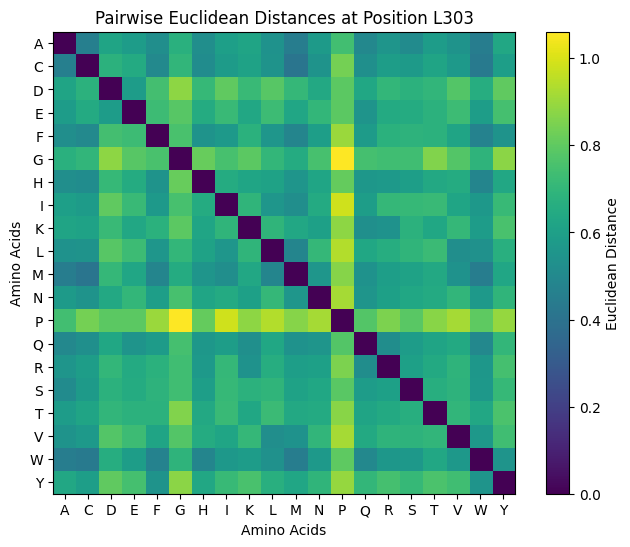

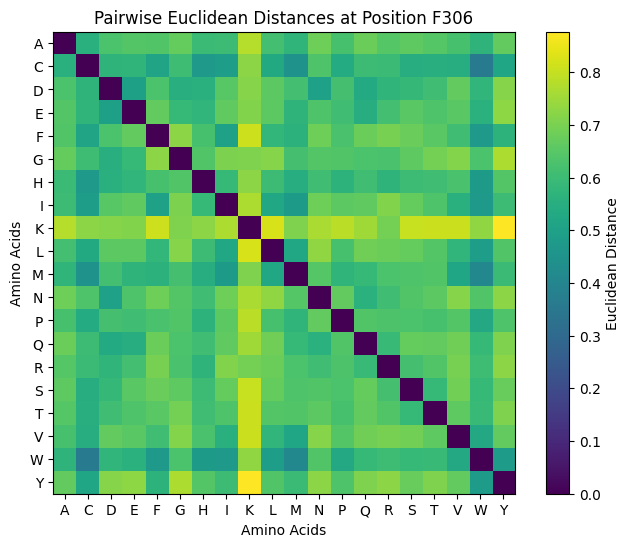

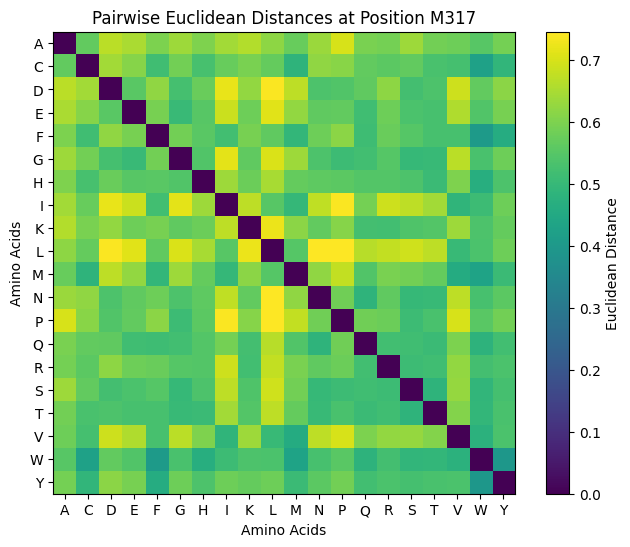

In [99]:
# for each position, plot the pairwise distances between amino acid embeddings
for pos, delta_emb in position_specific_embeddings.items():
    distances = squareform(pdist(delta_emb, metric='euclidean'))
    plt.figure(figsize=(8, 6))
    plt.imshow(distances, cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.xticks(ticks=range(len(amino_acids)), labels=amino_acids)
    plt.yticks(ticks=range(len(amino_acids)), labels=amino_acids)
    plt.title(f'Pairwise Euclidean Distances at Position {pos}')
    plt.xlabel('Amino Acids')
    plt.ylabel('Amino Acids')
    plt.show()